In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [2]:
mydir = '/glade/work/lettier/NUDGE/processed/spatial_mean_trend/ocn/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'ocn_sst-trend-annmean.1979-2018' in f and 'HADISST' not in f]

In [3]:
gridds = xr.open_dataset('/glade/scratch/lettier/AGU/seaice_conc_monthly_nh_1979-2018_remapcesmgrid.nc').isel(time=0)

In [4]:
listds = []
for file in myfiles: 
        ds = xr.open_dataset(file)
        if 'z_t' in ds:
            ds = ds.drop('z_t')
        ds = ds.set_coords('names')
        ds['TLONG'].values = gridds.TLON.values
        ds['TLAT'].values = gridds.TLAT.values
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [5]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [6]:
ds = xr.concat([ds,a60nudgemean],dim='names')

In [7]:
mynames = ['HADISST','LENSmean','aNUDGEmean']

In [8]:
obds = xr.open_dataset(mydir+'HADISST.ocn_sst-trend-annmean.1979-2018.nc')

In [9]:
lat1, lat2 = 50, 55
lon1, lon2 = 325, 335

In [10]:
mydir = '/glade/work/lettier/NUDGE/processed/timeseries/ocn/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'nawh' in f]

In [11]:
listds = []
for file in myfiles: 
        sstavgds = xr.open_dataset(file).squeeze()
        listds.append(sstavgds)
sstavgds = xr.concat(listds,dim='names')

thelens = [f for f in sstavgds.names.values if 'LENS' in f]
lensmean = sstavgds.isel(names=0).copy()
for var in sstavgds:
    lensmean[var] = sstavgds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean =lensmean.set_coords('names')

sstavgds = xr.concat([sstavgds,lensmean],dim='names')

In [12]:
mylist = []
for f in sstavgds.names.values:
    if 'LENSmean' in f:
        mylist.append({'label' : 'LENSmean', 'c' : 'tab:blue', 'linewidth' : 1.5, 'alpha' : 1.})
    elif 'LENS' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .5, 'alpha' : .3})
    elif '60' in f:
        mylist.append({'label' : 'aNUDGE', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
    else:
        mylist.append({'label' : 'HadISST', 'c' : 'k', 'linewidth' : 1.5, 'alpha' : 1.})
df = pd.DataFrame(mylist, index = sstavgds.names.values) 
df = df.transpose()

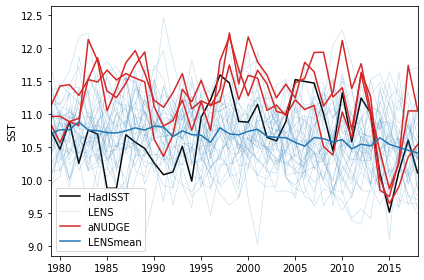

In [13]:
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
for n, name in enumerate(sstavgds.names.values):
            sstavgds.SST.groupby('time.year').mean(dim='time').sel(names=name).plot(ax = ax, **df[name].to_dict())     

ax.set_xlabel('')
ax.set_ylabel('SST')
ax.set_title('')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlim([1979,2018])
plt.tight_layout()
plt.show()
plt.close()

In [14]:
slope, intercept, r_value, p_value, std_err = myf.linregress(sstavgds.SST.groupby('time.year').mean(dim='time').year, sstavgds.SST.groupby('time.year').mean(dim='time').load(), dim='year')

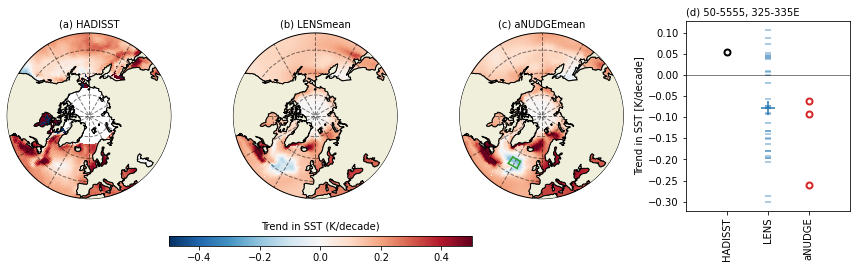

In [15]:
fig = plt.figure(figsize=(12,3.5))

for n, name in enumerate(mynames):
    ax = plt.subplot(1,len(mynames)+1,n+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 35,90], crs=ccrs.PlateCarree())
    label = ['a','b','c','d','e','f'][n]
    ax.set_title('('+str(label)+') '+name,fontsize=10,loc='center')
    
    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

    ax.coastlines()
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
  
    if n>0:
        mydata = 10.*ds.SST_trend.sel(names=name).squeeze()
        CS1 = ax.pcolormesh(ds.TLONG,ds.TLAT, mydata, vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                        transform=ccrs.PlateCarree())
    else:
        mydata = 10.*obds.SST_trend.squeeze()
        mydata = mydata.where(mydata.latitude<70)
        CS1 = ax.pcolormesh(obds.longitude,obds.latitude,mydata, vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                        transform=ccrs.PlateCarree())
        
ax.plot([lon1, lon2], [lat1, lat1], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon1, lon2], [lat2, lat2], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon1, lon1], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon2, lon2], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')

xlabels = ['HADISST','LENS','aNUDGE']

ax = plt.subplot(1,4,4)
for n, name in enumerate(slope.names.values):

    if 'LENSmean' in name:
        ax.scatter(2,10.*slope.sel(names=name), facecolor = df[name]['c'],marker='+',s=200)
    elif 'LENS' in name:
        ax.scatter(2,10.*slope.sel(names=name), facecolor = df[name]['c'],marker='_',alpha = .5)

    elif '60' in name:
        ax.scatter(3,10.*slope.sel(names=name), facecolor = 'white', edgecolors=df[name]['c'],marker='o',alpha = df[name]['alpha'],linewidth=2)
    else:
        ax.scatter(1,10.*slope.sel(names=name), facecolor = 'white', edgecolors=df[name]['c'],marker='o',alpha = df[name]['alpha'],linewidth=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(xlabels,rotation='vertical')
ax.set_ylabel('Trend in SST [K/decade]')
ax.set_xlim([0,4])
ax.axhline(y=0,c='k',linewidth=.5)
ax.set_title('(d) '+str(lat1)+'-55'+str(lat2)+', '+str(lon1)+'-'+str(lon2)+'E' ,fontsize=10,loc='left')
  
plt.tight_layout()
plt.subplots_adjust(hspace=.2, bottom = .15)
cbar_ax = fig.add_axes([0.2, 0.01, 0.35, 0.04]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Trend in SST (K/decade)',fontsize=10)
fig.savefig('figs/sst_trend.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [16]:
slope.names.values

array(['HADISST', 'LENS01', 'LENS02', 'LENS03', 'LENS04', 'LENS05',
       'LENS06', 'LENS07', 'LENS08', 'LENS09', 'LENS10', 'LENS11',
       'LENS12', 'LENS13', 'LENS14', 'LENS15', 'LENS16', 'LENS17',
       'LENS18', 'LENS19', 'LENS20', 'LENS21', 'LENS22', 'LENS23',
       'LENS24', 'LENS25', 'LENS26', 'LENS27', 'LENS28', 'LENS29',
       'LENS30', 'LENS31', 'LENS32', 'LENS33', 'LENS34', 'LENS35',
       'anom_nudge_era_60', 'anom_nudge_era_60_archi',
       'anom_nudge_era_60_arclo', 'LENSmean'], dtype=object)

In [17]:
np.count_nonzero(slope.values<0.)

27

In [18]:
p_value.values<0.05

array([False,  True, False,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False,  True, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True, False,  True,  True, False, False, False, False, False,
       False,  True, False,  True])

In [19]:
p_value.values

array([4.46456741e-01, 1.87341228e-02, 1.01797906e-01, 6.55109646e-03,
       6.46557794e-03, 1.29757436e-04, 9.92983868e-01, 4.18711418e-01,
       5.56397960e-01, 1.32123570e-02, 1.75523412e-01, 2.12642390e-01,
       7.52789046e-04, 7.09126449e-02, 3.71565492e-01, 4.83269745e-02,
       4.07272249e-01, 8.50485210e-01, 4.46685730e-01, 9.03811892e-01,
       4.97354540e-01, 7.75924242e-01, 4.50383445e-02, 1.98985557e-01,
       1.20051983e-01, 3.60686762e-03, 7.29221608e-03, 2.68169684e-06,
       7.49896004e-02, 2.27178895e-04, 6.22952606e-03, 1.70028750e-01,
       2.17539299e-01, 3.17510426e-01, 5.89648667e-01, 5.11904863e-01,
       4.07128171e-01, 1.84336926e-04, 1.77305849e-01, 6.06950023e-11])

In [20]:
p_value.names.values

array(['HADISST', 'LENS01', 'LENS02', 'LENS03', 'LENS04', 'LENS05',
       'LENS06', 'LENS07', 'LENS08', 'LENS09', 'LENS10', 'LENS11',
       'LENS12', 'LENS13', 'LENS14', 'LENS15', 'LENS16', 'LENS17',
       'LENS18', 'LENS19', 'LENS20', 'LENS21', 'LENS22', 'LENS23',
       'LENS24', 'LENS25', 'LENS26', 'LENS27', 'LENS28', 'LENS29',
       'LENS30', 'LENS31', 'LENS32', 'LENS33', 'LENS34', 'LENS35',
       'anom_nudge_era_60', 'anom_nudge_era_60_archi',
       'anom_nudge_era_60_arclo', 'LENSmean'], dtype=object)